In [133]:
import json
import requests
from openai import OpenAI
import os
import tiktoken
import random
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import concurrent.futures
import matplotlib.pyplot as plt

In [2]:
gpt_model = "gpt-3.5-turbo"
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [3]:
client = OpenAI()

In [4]:
def call_model(prompt,gpt_model):
    completion = client.chat.completions.create(model=gpt_model,
            messages=[{'role': 'user', 'content': prompt}],
            temperature=0.3)
    return completion.choices[0].message.content

### Step 1. Find classification tasks that are learnable in-context

In [5]:
ques_prefix = """
Here are 3 simple classification rules and example inputs which better explain when the rule is satisfied.
You have to create a composite rule which is a combination of all these 3 rules, and give 7 examples for that rule and write in similar format
Write only Rule, input and label, nothing else

Use the following structure to write them:

Rule: Example Rule
Input: input1 Label: True
Input: input2 Label: False
Input: input3 Label: False
Input: input4 Label: True
Input: input5 Label: False
Input: input6 Label: True
Input: input7 Label: False

Make sure to give atleast 7 examples
"""

In [6]:
with open("data/data_v2.json","r") as f:
    data = json.loads(f.read())

In [7]:
# the data contains groupings of rules as keys and values being hte rule level tasks

In [9]:
def get_n_rand_keys(dict_keys,n):
    return list(random.sample(list(dict_keys), n))

In [10]:
def pick_rand_sample(data):
    
    examples = []
    
    rules_groups = get_n_rand_keys(data,3)
    rule_set = []
    for rule_group in rules_groups:
        rule = get_n_rand_keys(data[rule_group],1)[0]
        example = "Rule: "+data[rule_group][rule]["example"]+"\n"+"\n".join(data[rule_group][rule]["inputs"])
        rule_set.append(data[rule_group][rule])
        examples.append(example)
    return examples,rule_set

In [11]:
def get_question_seed():
    ques_suffix,rule_set = pick_rand_sample(data)
    return ques_prefix+"\n\n".join(ques_suffix), rule_set

In [12]:
def num_tokens_from_string(string) -> int:
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [13]:
def get_tok_cost(token_count):
    return (0.001*token_count["input"]/1000)+(0.002*token_count["output"]/1000)

In [14]:
# dataset generation

In [30]:
def process_sample(idx):
    ques, rule_set = get_question_seed()
    token_count["input"] += num_tokens_from_string(ques)
    sample = call_model(ques,gpt_model)
    token_count["output"] += num_tokens_from_string(sample)
    #print("approx cost so far: {:.3f}".format(round(get_tok_cost(token_count), 3)))
    return sample, rule_set

# Assuming n_samples is the total number of iterations
n_samples = 250  # Replace this with the actual value

#data_list = []
token_count = {"input": 0, "output": 0}

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(process_sample, idx) for idx in range(n_samples)]

    # Manually update tqdm progress bar
    with tqdm(total=n_samples, desc="Processing samples") as pbar:
        for future in as_completed(futures):
            try:
                data_list.append(future.result())
                pbar.update(1)
            except KeyboardInterrupt:
                # Handle interrupt gracefully
                print("Interrupted. Partial results obtained so far.")
                break

In [29]:
len(data_list)

250

In [31]:
with open("data/composite_data_v2.txt","w") as f:
    for line in data_list:
        f.write("\n"+line[0]+"\n")

In [35]:
composite_rule_list = []
with open("data/composite_rules_v2.txt","w") as f:
    for line in data_list:
        composite_rule_list.append(line[1])
        f.write("\n"+str(line[1])+"\n")

In [47]:
with open("data/composite_data_v2.txt","r") as f: ## reading data after manual cleaning
    data_list = f.read().split("\n\n")

In [48]:
generated_data = []

for sample in tqdm(data_list):
    

    lines = sample.split("\n")
    if lines[-1] == '': lines = lines[:-1]
    rule = lines[0].split(": ")[1]
    try:
        x = lines[6].split("Input: ")[1].split(" Label")[0] # take only first 6 examples for ICL
        y = lines[6].split("Input: ")[1].split("Label: ")[1]
    except:
        # print lines that are incorrectly formatted
        print(lines[-1])
        
    generated_data.append({"rule":rule,"examples":lines[1:6], "x":x,"y":y})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 312262.06it/s]

Input: No specific rhyme scheme observed. Bananas are my favorite. Today is good day. Label: False
Input: She sat by the river. No technology company names mentioned. A cat on a mat. Label: False
Input: No special symbols here. No mythological references found. This is a Random sentence. Label: False
Input: This news is sad. A cat on a mat. No rhyming words. Label: False


In [50]:
len(generated_data)

250

In [51]:
template = """
Based on these examples
{examples}

predict the label for this
{input} Label: 
"""

In [52]:

# Function to process each sample in parallel
def process_sample(sample):
    examples = sample["examples"]
    input_to_predict = sample["x"]
    prompt = template.format(examples='\n'.join(examples), input=input_to_predict)
    resp = call_model(prompt,gpt_model)
    return [sample["y"], resp]

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map the function to the list of samples and retrieve results using tqdm
    predictions = list(tqdm(executor.map(process_sample, generated_data), total=len(generated_data)))

# Now predictions contains the results in parallel

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 22.35it/s]


In [53]:
with open("data/predictions_v2.txt","w") as f:
    for line in predictions:
        f.write("\n"+str(line)+"\n")

In [54]:
print(predictions[:20])

[['False', 'False'], ['False', 'False'], ['False', 'False'], ['True', 'True'], ['False', 'False'], ['False', 'True'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['True', 'False'], ['False', 'False'], ['False', 'True'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['False', 'False'], ['False', 'False']]


In [55]:
def get_acc(preds):
    score = []
    results = []
    for pred in preds:
        if pred[0].lower() in pred[1].lower(): # approximate string check!
            score.append(1.0)
        else:
            score.append(0.0)
    return (sum(score)*100/len(preds),score)

In [56]:
accuracy, results = get_acc(predictions) # results will be used later

In [57]:
print("Accuracy of label prediction:", f"{round(accuracy, 2)}%")
# TODO: get the accuracy above 90%

Accuracy of label prediction: 79.6%


### Step 2. Test the LLM’s ability to articulate the rules

In [58]:
rule_prediction_template = """
For the following examples 
{examples}

predict the rule that could be used to classify the examples as True or False

Option A: {ruleA} 

Option B: {ruleB} 

Option C: {ruleC} 

Option D: {ruleD}

respond with a single alphabet of the option and nothing else, only single alphabet
"""

In [59]:
# randomly pick 3 elements which are not equal to the current element?
def pick_random_elements(lst, excluded_element):
    # Filter elements that are not equal to the excluded element
    eligible_elements = [ele for ele in lst if ele != excluded_element]

    # Check if there are at least 3 eligible elements
    if len(eligible_elements) >= 3:
        # Randomly pick 3 elements from the eligible elements
        random_elements = random.sample(eligible_elements, 3)
        return random_elements
    else:
        print("Not enough eligible elements in the list.")
        return None

In [68]:
def process_sample(sample):
    examples = sample["examples"]
    input_to_predict = sample["x"]
    random_samples = pick_random_elements(generated_data, sample)
    rules = [item['rule'] for item in random_samples]
    rules.append(sample["rule"])
    random.shuffle(rules)
    rules_dict = dict(zip(["A", "B", "C", "D"], rules))

    prompt = rule_prediction_template.format(
        examples='\n'.join(examples),
        ruleA=rules_dict['A'],
        ruleB=rules_dict['B'],
        ruleC=rules_dict['C'],
        ruleD=rules_dict['D'])

    token_count["input"] += num_tokens_from_string(prompt)
    resp = call_model(prompt, gpt_model)
    token_count["output"] += num_tokens_from_string(resp)
    return [sample["rule"], resp, rules_dict]

# Assuming generated_data is your list of samples
# n_samples is the total number of iterations
n_samples = len(generated_data)  # Replace this with the actual value

rule_predictions = []
token_count = {"input": 0, "output": 0}

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(process_sample, sample) for sample in generated_data]

    # Manually update tqdm progress bar
    with tqdm(total=n_samples, desc="Processing samples") as pbar:
        for future in as_completed(futures):
            try:
                rule_predictions.append(future.result())
                pbar.update(1)
            except KeyboardInterrupt:
                # Handle interrupt gracefully
                print("Interrupted. Partial results obtained so far.")
                break

In [75]:
def get_classification_acc(rule_predictions):
    score = 0.0
    for pred in rule_predictions:
        option = pred[1][-1] # get single alphabet (some responses are like Option A instead of just A)
        if pred[2][option] == pred[0]: score+=1.0
    return (score*100/len(rule_predictions))

In [76]:
get_classification_acc(rule_predictions) # overall 61% accurate in predicting the rules all over the dataset
# this includes the options for both correctly classified labels and incorrectly classified ones

80.32128514056225

In [ ]:
# for the predictions which are true

In [137]:
subset_rule_predictions = [rule_pred for rule_pred, result in zip(rule_predictions, results) if result == 1]

In [138]:
classification_accuracy = get_classification_acc(subset_rule_predictions) # 63% overall 61% accurate in predicting the rules all over the dataset

In [139]:
# Print the result
print("Percentage of rules which are correct among the correctly predicted labels:", f"{round(classification_accuracy, 2)}%")

Percentage of rules which are correct among the correctly predicted labels: 81.82%


### Step 3. Investigating faithfulness

In [140]:
# there is a drop in accuracy between step-1 and step-2
# ~79% of the labels are correctly classified but only 63.29% of the rules are correctly identified by the model

In [141]:
def get_misclassified_rules(rule_predictions):
    misclassified_rules = []
    for pred in rule_predictions:
        option = pred[1][-1] # get single alphabet (some )
        if pred[2][option] != pred[0]:
            misclassified_rules.append(pred[0])
    return (misclassified_rules)

In [147]:
def get_misclassified_rules_individual(rule_predictions):
    misclassified_rules = []
    missed_rules = 
    for idx in range(len(rule_predictions)):
        pred = rule_predictions[idx]
        option = pred[1][-1] # get single alphabet (some )
        if pred[2][option] != pred[0]:
            misclassified_rules.append(pred[0])
    return (misclassified_rules)

In [142]:
misclassified_rules = get_misclassified_rules(subset_rule_predictions)

In [86]:
# the following are the rules for which the label is correctly classified but the rule is incorrectly identified

In [ ]:
# testing the LLM to check if it can generate examples for these rules correctly

In [ ]:
for rule in misclassified_rules:
    prompt = "write a sentance which will be labeled 'True' based on the following rule: "+rule
    resp = call_model(prompt)
    print(rule+"\n"+resp+"\n\n")

In [ ]:
# notes on misclassified rules along with model-generated examples

In [ ]:
rule_prefix = "The input is labeled as 'True' "

In [ ]:
missed_rules = [rule.split(rule_prefix)[1] for rule in misclassified_rules]

In [ ]:
list(data.keys())

In [ ]:
with open("data/icl_rules.json","r") as f:
    icl_rules = json.loads(f.read())

In [ ]:
icl_rules

In [ ]:
missed_rules

In [ ]:
missed_rule_words_prompt = """
split these rules into independant smaller rules and write in 1 word what they are related to,  for example if the rule is about "smiley face, the number of words is odd, and it reads the same backward as forward"  then write:

then write:

smily face
read backward
word count odd

in 3 separate lines


here are the rules: 
"""

In [ ]:
missclassified_rule_ideas = call_model(missed_rule_words_prompt+"\n".join(missed_rules))

In [ ]:
# transform missclassified_rule_ideas to a single list

In [ ]:
missclassified_rule_ideas = [
    ['smiley face', 'word count odd', 'read backward'],
    ['political term', 'special characters', 'word count greater than 5'],
    ['A-B-A rhyme scheme', 'all uppercase', 'smiley face'],
    ['@ symbol', 'contradictory statements', 'rhyming words'],
    ['special characters', "'apple'", 'date'],
    ['color', 'gender-specific pronouns', 'arithmetic progression word lengths'],
    ['numbers in exponential notation', 'special characters', 'word count greater than 5'],
    ['acronym', 'rhyming words', "'apple'"],
    ['geographical location', 'special characters', 'three consecutive consonants'],
    ['contradictory statements', 'future tense verbs', 'numeric digits'],
    ['technology company name', 'arithmetic progression word lengths', 'all uppercase'],
    ['acronym', 'all uppercase', 'special characters'],
    ['animal name', "'@' symbol", 'arithmetic progression word lengths'],
    ['mythology reference', 'more than 5 words', 'all uppercase'],
    ['even number of words', 'acronym or smiley face'],
    ['date', "'not' word", 'three consecutive consonants'],
    ['geographical location', 'comparative adjectives', 'Fibonacci sequence word lengths'],
    ['prime number letters', 'case alternates', 'all uppercase'],
    ['arithmetic progression word lengths', 'proper nouns', 'smiley face'],
    ['color', 'all uppercase', 'case alternates'],
    ['three consecutive consonants', 'Fibonacci sequence word lengths', 'comparative adjectives'],
    ['three words with the same starting letter', 'Fibonacci sequence word lengths', 'political term'],
    ['superlative adjectives', 'even number of words', 'three consecutive vowels'],
    ['future tense verbs', 'mathematical equation', "'@' symbol"],
    ["'@' symbol", 'even number of words', 'starts with a capital letter'],
    ['starts with a capital letter', 'three words with the same starting letter', 'acronym'],
    ['exclamation mark', 'contradictory statements', 'even number of words'],
    ['three consecutive consonants', 'three consecutive vowels', 'political term'],
    ['all uppercase', 'arithmetic progression word lengths', 'at least one adjective']
]

In [ ]:
missclassified_rule_ideas = [item for sublist in missclassified_rule_ideas for item in sublist]

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


# Combine all statements into a single string
text = " ".join(missclassified_rule_ideas)

# Additional stopwords to ignore
additional_stopwords = set(['if', 'it', 'contains', 'a', 'the', 'and', 'is', 'as', 'an', 'or', 'and', 'of', 
                            'in', 'to', 'with', 'for', 'at', 'on', 'by', 'has', 'have', 'that', 'this', 'it', 
                            'not', 'from', 'which','all', 'are', 'was', 'if', 'AND', 'OR', 'I', 'you', 'me',
                            "word","words","mentions"])

# Generate a word cloud, excluding common stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS.union(additional_stopwords)).generate(text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [88]:
# pie chart for misclassified predictions at label-label

In [92]:
def get_miss_classified_rule_at_labels(preds):
    score = []
    results = []
    
    for idx in range(len(preds)):
        if preds[idx][0].lower() in preds[idx][1].lower(): # approximate string check!
            score.append(1.0)
            miss_classified_rule_at_labels.append(composite_rule_list[idx])
        else:
            score.append(0.0)
    return (sum(score)*100/len(preds),score,miss_classified_rule_at_labels)

In [93]:
_, __, miss_classified_rule_at_labels = get_miss_classified_rule_at_labels(predictions)

In [98]:
miss_classified_rule_at_labels[0]

[{'example': "The input is labeled as 'True' if it reads the same backward as forward.",
  'inputs': ['Input: A man, a plan, a canal, Panama! Label: True',
   'Input: This is a Random sentence. Label: False']},
 {'example': "The input is labeled as 'True' if it contains the '@' symbol.",
  'inputs': ['Input: Email me @example.com. Label: True',
   'Input: No special symbols here. Label: False']},
 {'example': "The input is labeled as 'True' if the word lengths alternate between odd and even.",
  'inputs': ['Input: cat on mat. Label: True',
   'Input: Three mice ran away. Label: False']}]

In [89]:
# pie chart for misclassified predictions at rule-label

In [121]:
for level1_key, level1_value in data.items():
    for level2_key, level2_value in level1_value.items():
        rule_groups[level1_value[level2_key]["example"]] = level1_key


In [130]:
miss_classified_rule_at_labels_count = {}

rule_prefix = "The input is labeled as 'True' if "

for inner_list in miss_classified_rule_at_labels:
    for item in inner_list:
        example = item['example']
        miss_classified_rule_at_labels_count[rule_groups[example]] = miss_classified_rule_at_labels_count.get(rule_groups[example], 0) + 1

print(miss_classified_rule_at_labels_count)


{'Sentence Structure': 81, 'Symbol and Character Presence': 95, 'Word Count': 75, 'Grammatical': 84, 'Language Context': 95, 'Word Pattern and Structure': 74, 'Knowledge Domain': 93}


In [131]:
miss_classified_rule_at_labels_count

{'Sentence Structure': 81,
 'Symbol and Character Presence': 95,
 'Word Count': 75,
 'Grammatical': 84,
 'Language Context': 95,
 'Word Pattern and Structure': 74,
 'Knowledge Domain': 93}

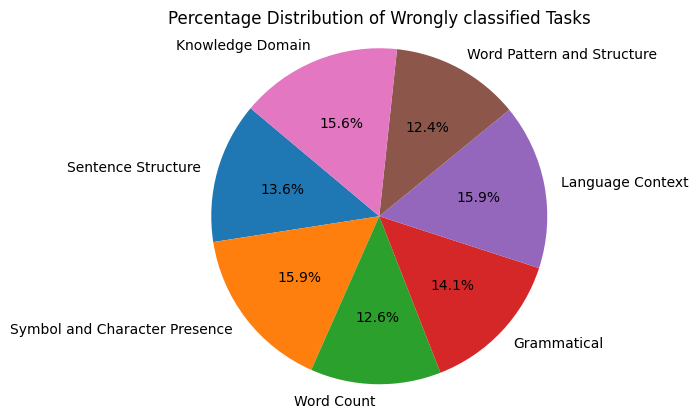

In [134]:
total = sum(miss_classified_rule_at_labels_count.values())
percentages = [(value / total) * 100 for value in miss_classified_rule_at_labels_count.values()]

# Create a pie chart
plt.pie(percentages, labels=miss_classified_rule_at_labels_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Wrongly classified Tasks')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Display the chart
plt.show()


In [ ]:
miss_classified_rule_at_rule_count = {}

rule_prefix = "The input is labeled as 'True' if "

for inner_list in miss_classified_rule_at_rule_count:
    for item in inner_list:
        example = item['example']
        miss_classified_rule_at_labels_count[rule_groups[example]] = miss_classified_rule_at_labels_count.get(rule_groups[example], 0) + 1

print(miss_classified_rule_at_labels_count)


In [136]:
misclassified_rules

["The input is labeled as 'True' if it contains the name of an animal, the '@' symbol, and reads the same backward as forward.",
 "The input is labeled as 'True' if it contains the name of an animal, contradictory statements, and a repeated letter.",
 "The input is labeled as 'True' if it starts with a capital letter, contains any special characters, and the number of letters in each word is a prime number.",
 "The input is labeled as 'True' if it contains contradictory statements and all words are in uppercase and mentions the name of a technology company.",
 "The input is labeled as 'True' if it contains verbs in the future tense, an exclamation mark, and the sentence structure resembles a question.",
 "The input is labeled as 'True' if it contains a repeated letter.",
 "The input is labeled as 'True' if it contains an exclamation mark, and the word lengths alternate between odd and even, and it contains numbers in exponential notation.",
 "The input is labeled as 'True' if it contai

In [144]:
misclassified_rules

["The input is labeled as 'True' if it contains the name of an animal, the '@' symbol, and reads the same backward as forward.",
 "The input is labeled as 'True' if it contains the name of an animal, contradictory statements, and a repeated letter.",
 "The input is labeled as 'True' if it starts with a capital letter, contains any special characters, and the number of letters in each word is a prime number.",
 "The input is labeled as 'True' if it contains contradictory statements and all words are in uppercase and mentions the name of a technology company.",
 "The input is labeled as 'True' if it contains verbs in the future tense, an exclamation mark, and the sentence structure resembles a question.",
 "The input is labeled as 'True' if it contains a repeated letter.",
 "The input is labeled as 'True' if it contains an exclamation mark, and the word lengths alternate between odd and even, and it contains numbers in exponential notation.",
 "The input is labeled as 'True' if it contai